**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* #Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* #Apply a distortion correction to raw images.
* #Use color transforms, gradients, etc., to create a thresholded binary image.
* #Apply a perspective transform to rectify binary image ("birds-eye view").
* #Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

** TWE **
* Outlier detection
* time dependent filtering
* plausibilisierung mit lane distane 

# Camera Calibration

In [365]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

In [366]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)

print('DONE')

DONE


ret: 1.4097909905429262


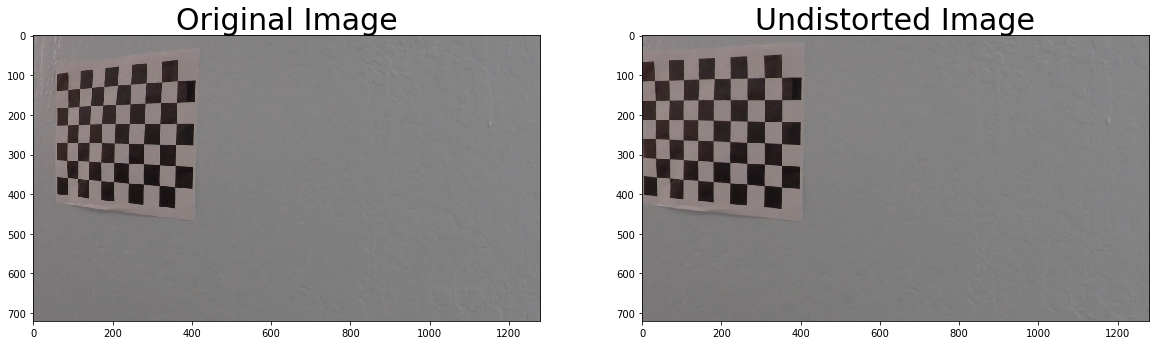

In [80]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration19.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
print("ret:",ret)

# Undistort image using camera matrix
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibration19_calibrated.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/cam_calibration.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30);

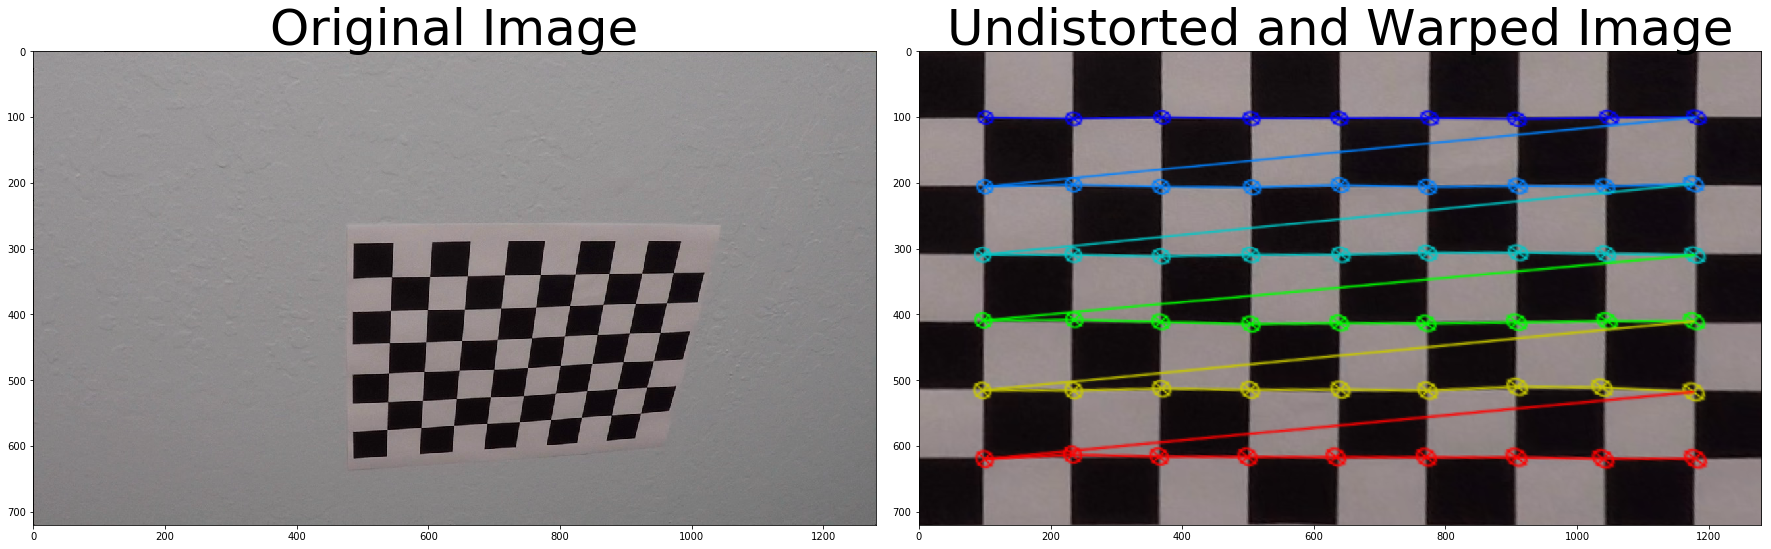

In [81]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True: 
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

# Read in an image
img = cv2.imread('camera_cal/calibration10.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

* *mtx*: 3x3 floating-point camera matrix $A = \begin{pmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{pmatrix}$
* *imgpoints*: image Points
* *objpoints*: object Points
* *dist*: distortion coefficients ($k_1$, $k_2$, $p_1$, $p_2$, $k_3$)
* *rvecs* vector of rotation vectors 
* *tvecs* vector of translation vectors
* *ret* root mean square (RMS) re-projection error ???

In [82]:
# Define a class to receive the characteristics of each line detection
class Camera():
    def __init__(self):
        # 
        self.mtx = None
        self.dist = None        
        # 
        self.src_3d = []
        self.dst_2d = []
        
    def calibrate(self, img_dir):
        return "TODO"
        
    def undistort_img(self, img):
        cam_data = pickle.load( open( "camera_cal/cam_calibration.p", "rb" ) )
        dst = cv2.undistort(img, cam_data['mtx'], cam_data['dist'], None, cam_data['mtx'])
        return dst        
        
    def warp_birdeye(self, img):
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points

        # Grab the image shape
        img_size = (img.shape[1], img.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])

        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)

        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(img, M, img_size)

        # Return the resulting image and matrix
        return warped        


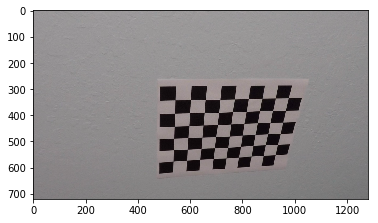

In [83]:
cam = Camera()
dst = cam.undistort_img(img)
plt.imshow(dst)
plt.show()

(720, 1280, 3)


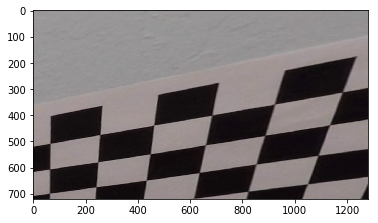

In [84]:
bird = warp_birdeye(dst)
print(bird.shape)
plt.imshow(bird)
plt.show()

In [179]:
class ImageFilter:
    # Define a function to threshold an image for a given range and Sobel kernel
    def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    # Define a function to return the magnitude of the gradient
    # for a given sobel kernel size and threshold values
    def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        # Return the binary image
        return binary_output
    
    # Define a function that takes an image, gradient orientation,
    # and threshold min / max values.
    def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

        # Return the result
        return binary_output
    
    # Edit this function to create your own pipeline.
    def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
        #    print(img)
        img = np.copy(img)
        # Convert to HSV color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]
        # Sobel x
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

        # Threshold color channel
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
        # be beneficial to replace this channel with something else.
        color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
        return color_binary, np.logical_or(sxbinary, s_binary)

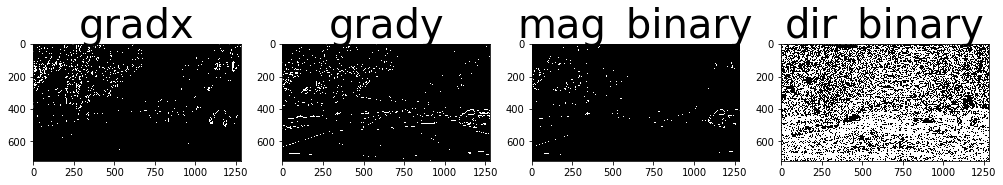

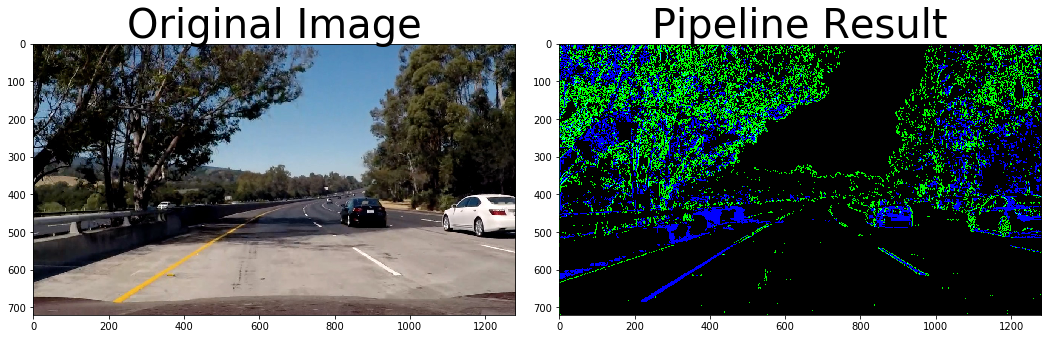

In [105]:
# Load image
image = cv2.imread('color-shadow-example.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = ImageFilter.abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 255))
grady = ImageFilter.abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(50, 255))
mag_binary = ImageFilter.mag_thresh(image, sobel_kernel=ksize, mag_thresh=(100, 255))
dir_binary = ImageFilter.dir_threshold(image, sobel_kernel=ksize, dir_thresh=(np.pi/4, np.pi/2))
result = ImageFilter.pipeline(image)

# Plot the result
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 9))
f.tight_layout()
ax1.imshow(gradx,cmap='gray');      ax1.set_title('gradx', fontsize=40)
ax2.imshow(grady,cmap='gray');      ax2.set_title('grady', fontsize=40)
ax3.imshow(mag_binary,cmap='gray'); ax3.set_title('mag_binary', fontsize=40)
ax4.imshow(dir_binary,cmap='gray'); ax4.set_title('dir_binary', fontsize=40)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
f.tight_layout()
ax1.imshow(image);  ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result); ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

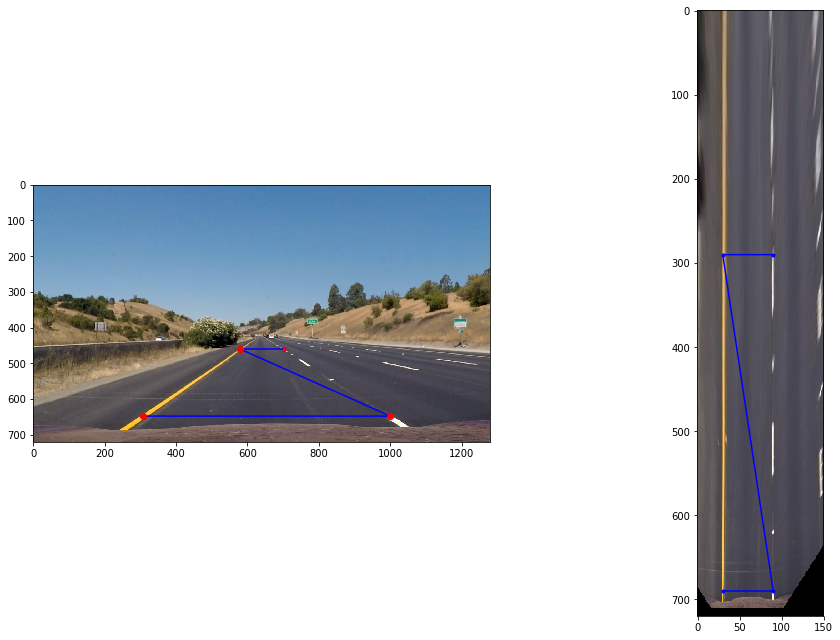

In [288]:
def warp_birdeye(img):
    # Choose offset from image corners to plot detected corners
    # This should be chosen to present the result at the proper aspect ratio
    # My choice of 100 pixels is not exact, but close enough for our purpose here
    offset_x = 30 # offset for dst points
    offset_y = -30    
    factor = 5

    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32([[308,648],[1000,648],[579,460],[703,460]])
    
    Lane_W = factor*(12) # ft (lande width)
    Lane_D = factor*(30+10+30+10) # ft (lane distance)

    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
#    dst = np.float32([[offset,        img_size[1]-offset],
#                      [Lane_W+offset, img_size[1]-offset], 
#                      [offset,        img_size[1]-Lane_D-offset], 
#                      [Lane_W+offset, img_size[1]-Lane_D-offset]])
    
    dst = np.float32([[offset_x,        img_size[1]+offset_y],
                      [Lane_W+offset_x, img_size[1]+offset_y], 
                      [offset_x,        img_size[1]-Lane_D+offset_y], 
                      [Lane_W+offset_x, img_size[1]-Lane_D+offset_y]])    

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)    

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, src, dst, M, Minv

# USA Lane width: 3.7 m (12ft)
# The finding holds implications for traffic safety. Each dashed line measures 10 feet, and the empty spaces in-between measure 30 feet.

image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_warp, src, dst, M, Minv = warp_birdeye(image)
#print(src)
#print(dst)

#bird = warp_birdeye(dst)
#print(bird.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 9))
#f, (ax1) = plt.subplots(1, 1, figsize=(14, 14))
f.tight_layout()
ax1.imshow(image)
ax1.plot(src[:,0],src[:,1],'b.-')
ax1.plot(src[0,0],src[0,1],'ro')
ax1.plot(src[1,0],src[1,1],'ro')
ax1.plot(src[2,0],src[2,1],'ro')
ax1.plot(src[3,0],src[3,1],'r.')
ax2.imshow(image_warp[0:,:150,:])
ax2.plot(dst[:,0],dst[:,1],'b.-')
plt.show()

In [358]:
#image = cv2.imread('test_images/straight_lines2.jpg')
img_width = 120
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# TODO: UNDISTORT
image = cam.undistort_img(image)
image_warp, src, dst, M, Minv = warp_birdeye(image)
image_warp_org = image_warp.copy()
image_warp = image_warp[:,:img_width,:];
delme, binary_img = ImageFilter.pipeline(image)
binary_img = np.array(np.dstack((binary_img, binary_img, binary_img)), np.uint8)
binary_warp, src, dst, M, Minv = warp_birdeye(binary_img)
binary_warp = binary_warp[:,:img_width,0];

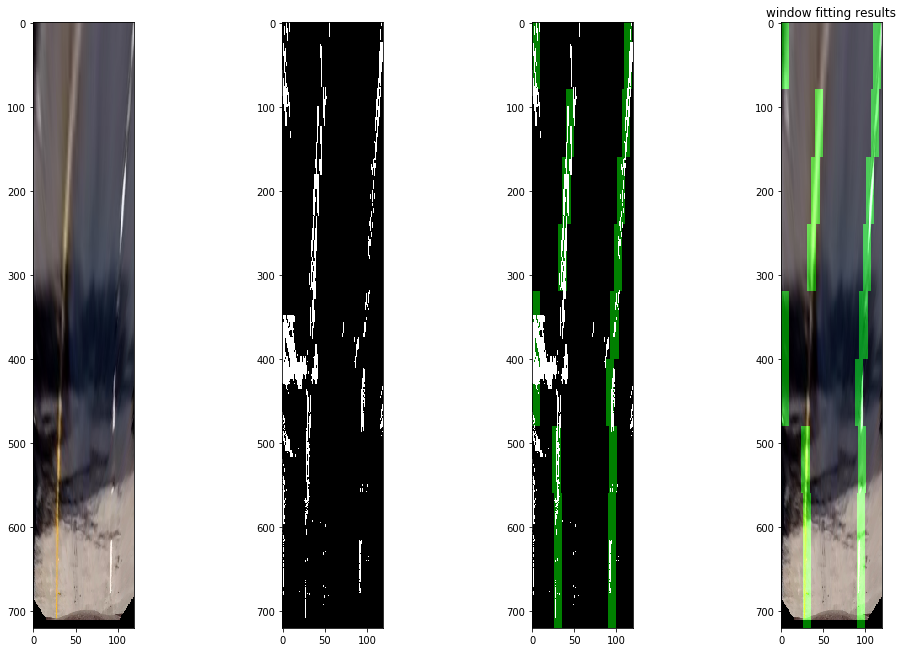

In [359]:
# window settings
window_width = 10 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 40 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(binary_warp, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(binary_warp)
    r_points = np.zeros_like(binary_warp)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,binary_warp,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,binary_warp,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channle 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((binary_warp,binary_warp,binary_warp)),np.uint8) # making the original road pixels 3 color channels
    output1 = cv2.addWeighted(warpage*255, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    output2 = cv2.addWeighted(image_warp, 1, template, 0.5, 0.0) # overlay the orignal road image with window results    

# If no window centers found, just display orginal road image
else:
    output1 = np.array(cv2.merge((binary_warped,binary_warped,binary_warped)),np.uint8)
    output2 = output1

# Display the final results
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(14, 9))
f.tight_layout()
ax1.imshow(image_warp)
ax2.imshow(binary_warp,cmap='gray')
ax3.imshow(output1)
ax4.imshow(output2)
plt.title('window fitting results')
plt.show()

In [360]:
data = np.array(window_centroids)
print(data)
ploty = (window_height/2 + np.linspace(0, 630, num=720/window_height)) / 1
print(ploty)
leftx = data[:,0]
rightx = data[:,1]

[[  31.   95.]
 [  31.   95.]
 [  29.   96.]
 [   4.   93.]
 [   5.   98.]
 [  36.  102.]
 [  41.  106.]
 [  45.  112.]
 [   5.  114.]]
[  40.    118.75  197.5   276.25  355.    433.75  512.5   591.25  670.  ]


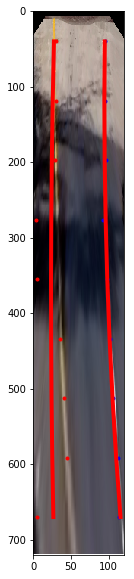

In [361]:
#import numpy as np
#import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
#leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                              for y in ploty])
#rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                for y in ploty])
#
#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit   = np.polyfit(ploty, leftx, 2)
left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit  = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr  = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2) 

# Plot up the fake data
plt.figure(figsize=(20,10))
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
#plt.xlim(0, 1280)
#plt.ylim(0, 720)
plt.xlim(0, 120)
plt.ylim(0, 720)
plt.imshow(np.flipud(image_warp))
plt.plot(left_fitx, ploty, color='red', linewidth=4)
plt.plot(right_fitx, ploty, color='red', linewidth=4)
plt.gca().invert_yaxis() # to visualize as we do the images

In [362]:
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

4705.34462893 m 2295.6041753 m


In [363]:
ploty = (window_height/2 + np.linspace(0, 630, num=720)) / 1
left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

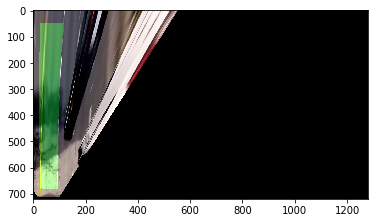

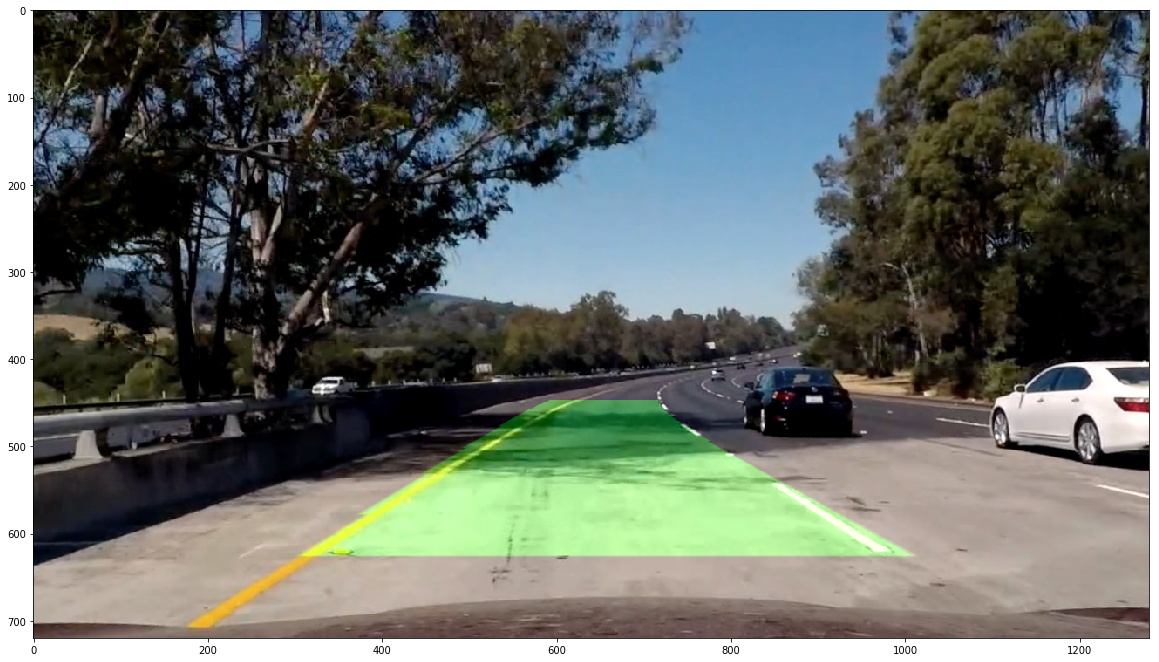

In [364]:
# Create an image to draw the lines on
color_warp = np.zeros_like(image).astype(np.uint8)

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left  = np.array([np.transpose(np.vstack([left_fitx, color_warp.shape[0]-ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, color_warp.shape[0]-ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
if True:
    result0 = cv2.addWeighted(image_warp_org, 1, color_warp, 0.3, 0)
    plt.imshow(result0)
    plt.show()

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.figure(figsize=(20,14))
plt.imshow(result)
plt.show();

# OLD

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None


In [344]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

8099.07005604 11099.9682618


In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)

    show_final_results = True; # False = Only hough lines, True = average lines
    result = lane_pipline(image, False, False, not show_final_results)
    
    return result

white_output = 'project_video.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
import time
filename = white_output + ( "?t=" + str(time.time()) ); # disable firefox video caching by adding random number
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(filename))

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points
###Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---
###Writeup / README

####1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!
###Camera Calibration

####1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]

###Pipeline (single images)

####1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
![alt text][image2]
####2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

![alt text][image3]

####3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warper()`, which appears in lines 1 through 8 in the file `example.py` (output_images/examples/example.py) (or, for example, in the 3rd code cell of the IPython notebook).  The `warper()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![alt text][image4]

####4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

![alt text][image5]

####5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines # through # in my code in `my_other_file.py`

####6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]

---

###Pipeline (video)

####1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

###Discussion

####1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  



In [33]:
help(cv2.calibrateCamera)

Help on built-in function calibrateCamera:

calibrateCamera(...)
    calibrateCamera(objectPoints, imagePoints, imageSize, cameraMatrix, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]) -> retval, cameraMatrix, distCoeffs, rvecs, tvecs



# OLD

In [367]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

14334.8346252 7052.12424566


In [ ]:
help(cv2.calibrateCamera)

In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
#quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
#leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                              for y in ploty])
#rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
#                                for y in ploty])
#
#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

In [ ]:
x = np.array([0.0, 1.0, 2.0, 3.0,  4.0,  5.0])
y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1000.0])

best_mse    = 1e99;
best_result = None;
best_choice = None;
for i in range(100): # implement RANSAC
#    r = np.random.choice([False, True], size=(len(x),), p=np.array([10, 90])/100.)
    r = np.ones(shape=(len(x),), dtype=np.bool)
    r[np.random.randint(0,len(x))] = False;
    r[np.random.randint(0,len(x))] = False;      
    result = np.polyfit(x[r], y[r], 2, full=True)
#    mse = np.sum(result[0]**2)
    mse = result[1][0];
    if mse < best_mse:
        best_mse    = mse;
        best_result = result;
        best_choice = r;
    
print("Result:")
print(best_mse)
print(best_result)
print(best_choice)
result = best_result[0]

print(result)


In [ ]:
x = np.array([0.0, 1.0, 2.0, 3.0])
y = np.array([0.0, 0.8, 0.9, 0.9])
z = np.polyfit(x, y, 2, full=True)
print(z)
#print(np.sum(z[0]**2))

In [ ]:
import scipy
scipy.signal.detrend([0, 1, 2, 3, 4, 5, 99])